# Mini-projet : classification de battements cardiaques

## Nom du binôme :

Cet ensemble de données a été créé à l'origine pour un défi d'apprentissage automatique visant à classer les bruits de battements cardiaques.

<img src="files/BattementCardiaque.PNG" width="600" height="300"  >

Les données ont été recueillies auprès de deux sources :
- (A) auprès du grand public via une application de smartphone,
- (B) dans le cadre d'un essai clinique dans des hôpitaux utilisant le stéthoscope numérique.


Les enregistrements de ces 2 sources étant de durées différentes, ils ont été ensuite transformés en MFCC pour extraire le contenu fréquentiel de ces données.


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import librosa
import IPython.display as ipd

import matplotlib.pyplot as plt
import sklearn
import math
from scipy import stats
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
print(np.__version__)
print(sklearn.__version__)

from google.colab import files
uploaded = files.upload()

1.23.5
1.2.2


Saving normalB.wav to normalB.wav
Saving normalA.wav to normalA.wav
Saving murmurB.wav to murmurB.wav
Saving murmurA.wav to murmurA.wav
Saving DataMFCC_setB.csv to DataMFCC_setB.csv
Saving DataMFCC_setA.csv to DataMFCC_setA.csv
Saving DataMFCC.csv to DataMFCC.csv
Saving BattementCardiaque.png to BattementCardiaque.png
Saving artifactA.wav to artifactA.wav


## Exemples de sons de l'ensemble A de battements cardiaques à classer



In [ ]:
# Son d'un battement normal
x0,sr0=librosa.load("normalA.wav",duration=5)
ipd.Audio(x0,rate=sr0)


In [ ]:
# Son d'un murmure cardiaque

x1,sr1=librosa.load("murmurA.wav",duration=5)
ipd.Audio(x1,rate=sr1)

In [ ]:
# Son d'un artefact
x3,sr3=librosa.load("artifactA.wav",duration=5)
ipd.Audio(x3,rate=sr3)

## Exemples de sons de l'ensemble B de battements cardiaques à classer



In [ ]:
# Son d'un battement normal - ensemble B
x4,sr4=librosa.load("normalB.wav",duration=5)
ipd.Audio(x4,rate=sr4)


In [ ]:
# Son d'un murmure cardiaque - ensemble B

x5,sr5=librosa.load("murmurB.wav",duration=5)
ipd.Audio(x5,rate=sr5)

## Chargement des données

A chaque enregistrement, 20 coefficients MFCC sont calculés en réalisant la moyenne sur chaque fenêtre de 10ms.

*DataMFCC.csv* regroupe tous les enregistrements des 2 dispositifs.

Le fichier source *DataMFCC.csv* sur lequel vous travaillez est la conversion des enregistrements audio en matrice de paramètres appélés MFCC (Mel Frequency Cepstral Coefficient) en utilisant la librairie python *librosa*. Ces paramètres permettent d'extraire au mieux le contenu vocal fréquenciel du signal audio.

La matrice de données est composée d'autant de vecteurs lignes que de fichiers audio. Le nombre de colonnes correspond à la dimension du vecteur moyen représentatif des MFCC : ici 20.

In [ ]:
dataA = pd.read_csv('DataMFCC_setA.csv')



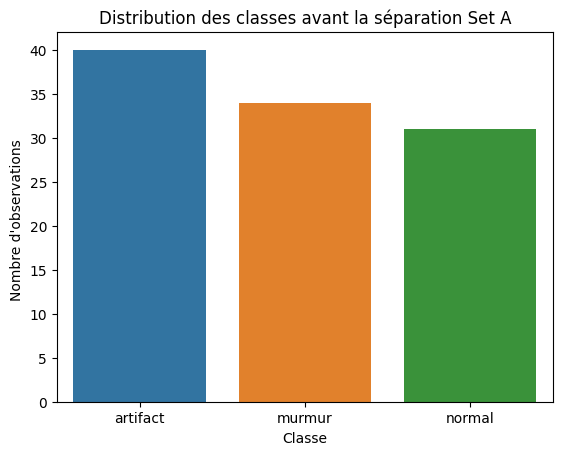

In [ ]:
# Comptage des occurrences de chaque classe
class_counts = dataA['label'].value_counts()

# Création du graphique en barres
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations ')
plt.title('Distribution des classes avant la séparation Set A')
plt.show()


In [ ]:
dataB = pd.read_csv('DataMFCC_setB.csv')



In [ ]:
# Nombre d'observations dans la classe la moins représentée
n_normal = dataA[dataA['label'] == 'normal'].shape[0]

# Sous-échantillonnage de la classe 'normal'
data_artifact_sampled = dataA[dataA['label'] == 'artifact'].sample(n=n_normal, random_state=10)

# Sous-échantillonnage de la classe 'murmur' si nécessaire
data_murmur_sampled = dataA[dataA['label'] == 'murmur'].sample(n=n_normal, random_state=10)

# Combinez les sous-ensembles équilibrés en un seul DataFrame
data_balanced = pd.concat([data_artifact_sampled, data_murmur_sampled, dataA[dataA['label'] == 'normal']])
print(data_balanced['label'].value_counts())


artifact    31
murmur      31
normal      31
Name: label, dtype: int64


In [ ]:
X=data_balanced.iloc[:,0:20]


In [ ]:
from sklearn.preprocessing import LabelEncoder

# Encode le label de chaque classe par un chiffre
ylabel=data_balanced["label"]
le=LabelEncoder().fit(ylabel)
y=le.transform(ylabel)




In [ ]:
# création de la base d'apprentissage et de test
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=31,stratify=y)

print("Base d'apprentissage - X_Train: ",len(X_train),"\n","Base de test - X_Test: ",len(X_test),sep="")
print(type(X_train))
print(type(X_test))

Base d'apprentissage - X_Train: 69
Base de test - X_Test: 24
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
# Description de l'ensemble d'apprentissage
values,count=np.unique(y_train, return_counts=True)

print('label:',values,'nbre de valeurs:',count )

label: [0 1 2] nbre de valeurs: [23 23 23]


### Fonctions pour réaliser une table de correspondance entre le label des approches non supervisées et le label réel

In [ ]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels

# Méthodes d'apprentissage supervisé

Appliquer au moins 3 méthodes d'apprentissage supervisé et faire une étude sur les paramètres inhérents


<h3 style="color:#00008B; font-family: Didot, serif;">1. Méthode supervisée (KNN : k nearest neighbors) : </h3>

### A. Algorithme

Le KNN est un algorithme de classification supervisé. Pour chaque observation $x_{i}=(x^{1}_{i}, x^{1}_{i}, x^{2}_{i}, ... x^{n}_{i}) $ , nous avons une étiquette associée $y_{i}$, qui représente la classe de $x_{i}$.

Pour classer un nouveau vecteur \( x \) à l'aide de KNN :

1. Calculez la distance (souvent euclidienne, mais d'autres métriques peuvent être utilisées) entre x  et chaque échantillon  $x_{i}$ dans l'ensemble d'entraînement.
2. Identifiez les k  échantillons  $x_{i}$ les plus proches de x .
3. La classe attribuée à x  sera celle qui est majoritairement représentée parmi ces k  voisins les plus proches.

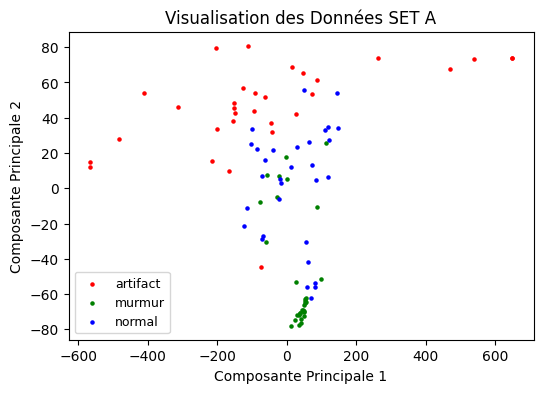

In [ ]:
from sklearn.decomposition import PCA

# Fonction pour tracer les données
def plot_blobs(X, y, title="Visualisation des Données SET A"):
    plt.figure(figsize=(6, 4))
    plt.scatter(X[np.where(y == 0), 0], X[np.where(y == 0), 1], s=5, color='r', label="artifact")
    plt.scatter(X[np.where(y == 1), 0], X[np.where(y == 1), 1], s=5, color='g', label="murmur")
    plt.scatter(X[np.where(y == 2), 0], X[np.where(y == 2), 1], s=5, color='b', label="normal")
    plt.legend(loc=0, prop={'size': 9})
    plt.title(title)
    plt.xlabel("Composante Principale 1")
    plt.ylabel("Composante Principale 2")

# Réduction de dimensionnalité avec PCA
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Tracé des données réduites
plot_blobs(X_reduced, y)
plt.show()



In [ ]:
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()
X_train_np = np.ascontiguousarray(X_train_np)
X_test_np = np.ascontiguousarray(X_test_np)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

accuracys = []
cms = []
for i in range(1, 13, 2):
    neight = KNeighborsClassifier(n_neighbors=i)
    neight.fit(X_train_np, y_train)
    y_pred = neight.predict(X_test_np)
    accuracys.append(accuracy_score(y_test, y_pred))
    cms.append(confusion_matrix(y_test, y_pred))



**Remarque** Le problème était lié à la structure des données en mémoire et a été résolu en convertissant les données en un format approprié

In [ ]:
#accuracy for each value of k
K = {}
for i in range(len(accuracys)):
    K[ i+(i+1%2) ] = accuracys[i]
    print("k = {} \t | \t accuracy = {}".format(str(i+(i+1%2)),accuracys[i]))

k = 1 	 | 	 accuracy = 0.6666666666666666
k = 3 	 | 	 accuracy = 0.6666666666666666
k = 5 	 | 	 accuracy = 0.5833333333333334
k = 7 	 | 	 accuracy = 0.625
k = 9 	 | 	 accuracy = 0.6666666666666666
k = 11 	 | 	 accuracy = 0.7083333333333334


##### Trace la precision de ce modele en fonction de k. quel valeur de k choisir pour ce problème?

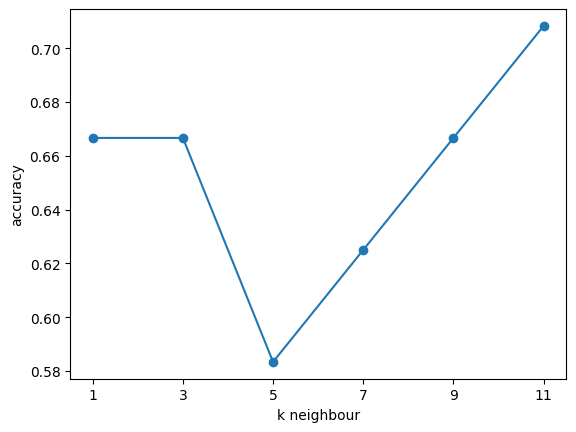

In [ ]:
#plot accuracy
plt.plot(np.arange(1,13,2),np.array(accuracys),marker="o")
plt.xticks(np.arange(1, 13,2))
plt.xlabel('k neighbour')
plt.ylabel('accuracy')
plt.show()

In [ ]:
def get_max_K(K):
    max_value = max(K.values())
    max_keys = [k for k, v in K.items() if v == max_value]
    return max_keys[0]

print("la valeur optimale de k pour ce probleme est: ",get_max_K(K))

la valeur optimale de k pour ce probleme est:  11


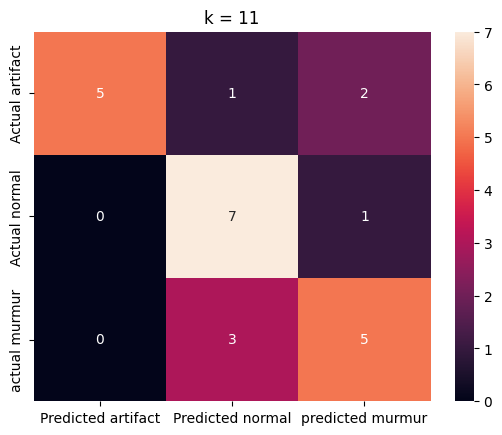

In [ ]:
plt.title("k = 11")
sns.heatmap(cms[5
               ],annot=True,fmt="d" ,xticklabels=['Predicted artifact', 'Predicted normal' , 'predicted murmur'],
            yticklabels=['Actual artifact', 'Actual normal' , 'actual murmur'])
plt.show()


##RANDOM FOREST :

Précision de la Random Forest: 0.7916666666666666


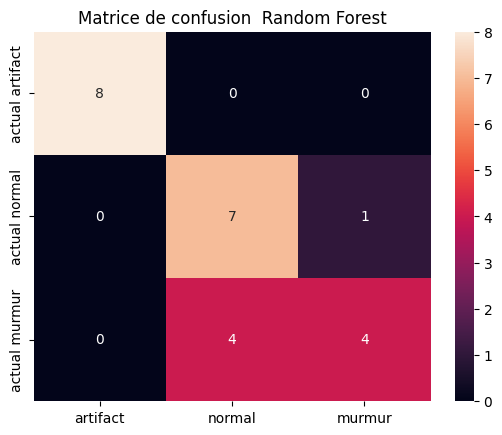

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Création du modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle Random Forest
rf_model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred_rf = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Précision de la Random Forest:", accuracy_rf)

# Calcul de la matrice de confusion
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

#labels des axis X / Y
class_labelsX = ['artifact', 'normal', 'murmur']
class_labelsY = ['actual artifact', 'actual normal', 'actual murmur']


plt.title('Matrice de confusion  Random Forest')
sns.heatmap(conf_matrix_rf,annot=True,fmt="d" ,xticklabels=class_labelsX, yticklabels=class_labelsY )
plt.show()


# Méthode non supervisée
 K-MEANS:

Appliquer au moins une méthode non supervisée

 
 Matrice de confusion :



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


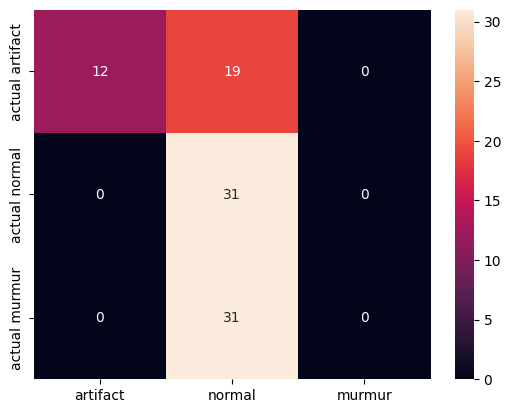


Score de précision : 0.46236559139784944


In [ ]:

from sklearn.cluster import KMeans
# On fixe le nombre de clusters au nombre d'étiquettes uniques dans notre ensemble de données
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

#ajuster le modèle et obtenir les clusters
y_pred = kmeans.fit_predict(X)

#obtenir une correspondance entre les clusters de K-means et les véritables étiquettes
y_pred_label = correspondance(y_pred, y)

# Calcul de la matrice de confusion
cm = confusion_matrix(y, y_pred_label)

# Calcul du score de précision
accuracy = accuracy_score(y, y_pred_label)

print(" \n Matrice de confusion :\n")

class_labelsX = ['artifact', 'normal', 'murmur']
class_labelsY = ['actual artifact', 'actual normal', 'actual murmur']

sns.heatmap(cm,annot=True,fmt="d" , xticklabels=class_labelsX, yticklabels=class_labelsY )
plt.show()

print("\nScore de précision :", accuracy)


## MFCC B

normal    320
murmur     95
Name: label, dtype: int64


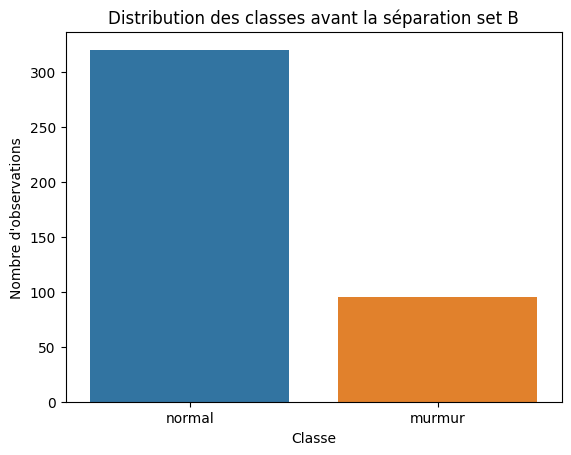

In [ ]:
dataB = pd.read_csv('DataMFCC_setB.csv')


# Comptage des occurrences de chaque classe
class_counts = dataB['label'].value_counts()
print(class_counts)

# Création du graphique en barres
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.title('Distribution des classes avant la séparation set B')
plt.show()


In [ ]:

# Nombre d'observations dans la classe la moins représentée
n_murmurB = dataB[dataB['label'] == 'murmur'].shape[0]

# Sous-échantillonnage de la classe 'normal'
data_normal_sampledB = dataB[dataB['label'] == 'normal'].sample(n=n_murmurB, random_state=10)



# Combinez les sous-ensembles équilibrés en un seul DataFrame
data_balancedB = pd.concat([data_normal_sampledB,  dataB[dataB['label'] == 'murmur']])

# Vérifiez la distribution des classes après le rééchantillonnage
print(data_balancedB['label'].value_counts())









normal    95
murmur    95
Name: label, dtype: int64


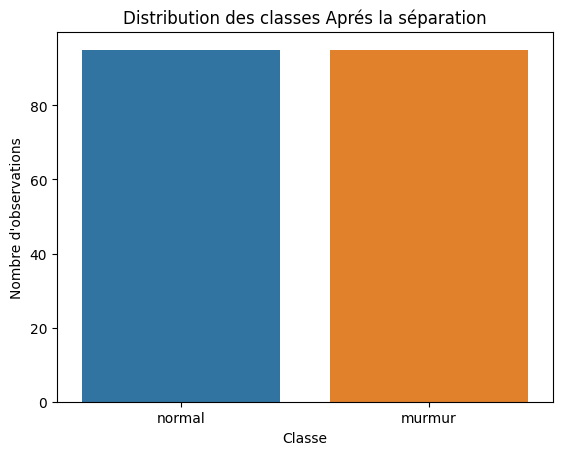

In [ ]:
class_counts = data_balancedB['label'].value_counts()

# Création du graphique en barres
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.xlabel('Classe')
plt.ylabel('Nombre d\'observations')
plt.title('Distribution des classes Aprés la séparation')
plt.show()










In [ ]:
# création de la base d'apprentissage et de test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X_B=data_balancedB.iloc[:,0:20]




# Encode le label de chaque classe par un chiffre
ylabelb=data_balancedB["label"]
leb=LabelEncoder().fit(ylabelb)
yb=leb.transform(ylabelb)
print(X_B.shape)
print(yb.shape)
yb = yb.ravel()





(190, 20)
(190,)


In [ ]:
X_trainb,X_testb,y_trainb,y_testb=train_test_split(X_B,yb,test_size=0.25,random_state=31,stratify=yb)

print("Base d'apprentissage - X_Train: ",len(X_train),"\n","Base de test - X_Test: ",len(X_test),sep="")
print(type(X_trainb))
print(type(X_testb))

Base d'apprentissage - X_Train: 69
Base de test - X_Test: 24
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [ ]:
values,count=np.unique(y_trainb, return_counts=True)

print('label:',values,'nbre de valeurs:',count )

label: [0 1] nbre de valeurs: [71 71]


##KNN :

In [ ]:
accuracy= []
cm = []
for i in range(1, 13, 2):
    neight = KNeighborsClassifier(n_neighbors=i)
    neight.fit(X_trainb, y_trainb)
    y_predb = neight.predict(X_testb)
    accuracy.append(accuracy_score(y_testb, y_predb))
    cm.append(confusion_matrix(y_testb, y_predb))


K = {}
for i in range(len(accuracy)):
    K[ i+(i+1%2) ] = accuracy[i]
    print("k = {} \t | \t accuracy = {}".format(str(i+(i+1%2)),accuracy[i]))


k = 1 	 | 	 accuracy = 0.6875
k = 3 	 | 	 accuracy = 0.7916666666666666
k = 5 	 | 	 accuracy = 0.7708333333333334
k = 7 	 | 	 accuracy = 0.7291666666666666
k = 9 	 | 	 accuracy = 0.7708333333333334
k = 11 	 | 	 accuracy = 0.7291666666666666


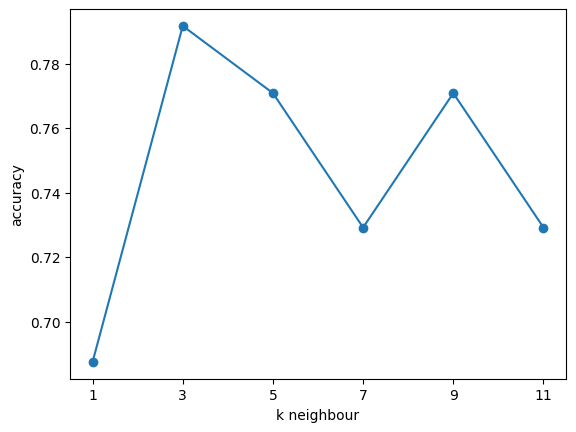

In [ ]:
#plot accuracy
plt.plot(np.arange(1,13,2),np.array(accuracy),marker="o")
plt.xticks(np.arange(1, 13,2))
plt.xlabel('k neighbour')
plt.ylabel('accuracy')
plt.show()

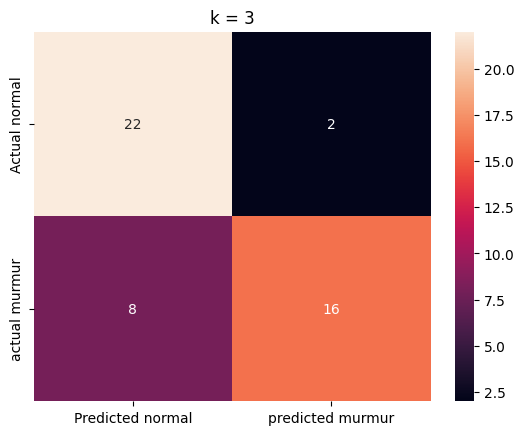

0.7916666666666666


In [ ]:
plt.title("k = 3")
sns.heatmap(cm[1
               ],annot=True,fmt="d" ,xticklabels=[ 'Predicted normal' , 'predicted murmur'],
            yticklabels=[ 'Actual normal' , 'actual murmur'])
plt.show()
print(accuracy[1])

##RANDOM FOREST :

Précision de la Random Forest: 0.7291666666666666


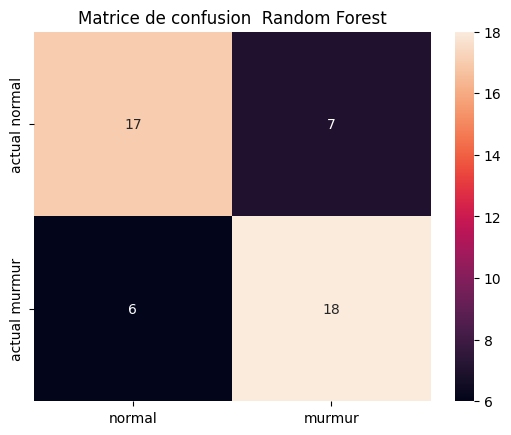

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Création du modèle Random Forest
rf_modelb = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraînement du modèle Random Forest
rf_model.fit(X_trainb, y_trainb)

# Prédiction sur l'ensemble de test
y_pred_rfb = rf_model.predict(X_testb)

accuracy_rfb = accuracy_score(y_testb, y_pred_rfb)
print("Précision de la Random Forest:", accuracy_rfb)

# Calcul de la matrice de confusion
conf_matrix_rfb = confusion_matrix(y_testb, y_pred_rfb)

#labels des axis X / Y
class_labelsX = [ 'normal', 'murmur']
class_labelsY = [ 'actual normal', 'actual murmur']


plt.title('Matrice de confusion  Random Forest')
sns.heatmap(conf_matrix_rfb,annot=True,fmt="d" ,xticklabels=class_labelsX, yticklabels=class_labelsY )
plt.show()


##NON SUPERVISE : K-MEANS


 
 Matrice de confusion :



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


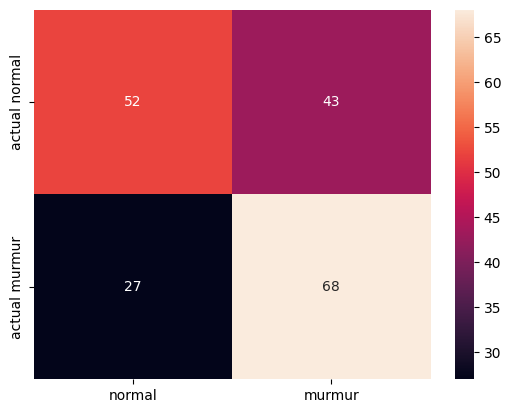


Score de précision : 0.631578947368421


In [ ]:

from sklearn.cluster import KMeans
# On fixe le nombre de clusters au nombre d'étiquettes uniques dans notre ensemble de données
n_clusters = 2
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

#ajuster le modèle et obtenir les clusters
y_predb = kmeans.fit_predict(X_B)

#obtenir une correspondance entre les clusters de K-means et les véritables étiquettes
y_pred_labelb = correspondance(y_predb, yb)

# Calcul de la matrice de confusion
mc = confusion_matrix(yb, y_pred_labelb)

# Calcul du score de précision
accuracyK = accuracy_score(yb, y_pred_labelb)

print(" \n Matrice de confusion :\n")

class_labelsX = [ 'normal', 'murmur']
class_labelsY = [ 'actual normal', 'actual murmur']

sns.heatmap(mc,annot=True,fmt="d" , xticklabels=class_labelsX, yticklabels=class_labelsY )
plt.show()

print("\nScore de précision :", accuracyK)


##ACP K-MEANS SET A :

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# encoder les variables catégorielles avant d'appliquer l'ACP avec la méthode des dummies
data_encodedA = pd.get_dummies(data_balanced)

# Standardisation des données
scaler = StandardScaler()
data_scaledA = scaler.fit_transform(data_encodedA)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[2139.0, 1481.5881457408104, 1185.9643397328214, 981.6174748201573, 861.3313478630487, 779.7139052064693, 688.3557636080104, 593.9645566888119, 515.3667544827839, 445.79354232030323, 398.1930670115117, 356.3226448755625]


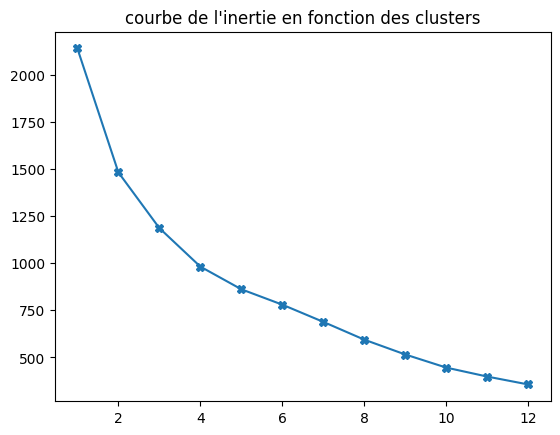

In [ ]:
inertie=[]
for c in  range (1, 13):
  kmeans = KMeans (init = 'k-means++' , n_clusters=c)
  kmeans.fit(data_scaledA)
  inertie.append(kmeans.inertia_)
print (inertie)
plt.figure()
plt.plot(range(1,13) , inertie,marker='X')
plt.title("courbe de l'inertie en fonction des clusters")
plt.show()

Shape of data_pca: (93, 4)
Shape of y: (93,)

Matrice de confusion :


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


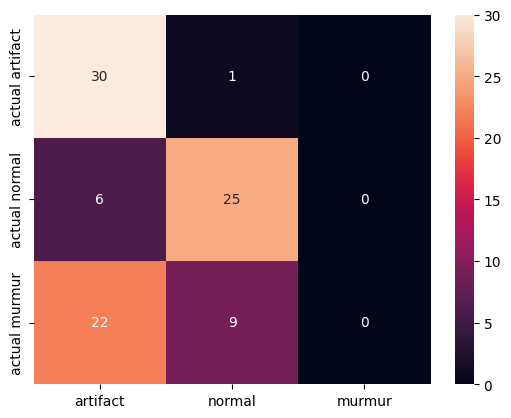


Score de précision : 0.5913978494623656


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Réduction de dimension avec PCA
n_components = 4
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_scaledA)

print("Shape of data_pca:", data_pca.shape)
print("Shape of y:", y.shape)

kmeans = KMeans(n_clusters=2, random_state=0)
y_pred = kmeans.fit_predict(data_pca)
y_pred_label = correspondance(y_pred, y)

# Calcul de la matrice de confusion
cm = confusion_matrix(y, y_pred_label)

# Calcul du score de précision
accuracy = accuracy_score(y, y_pred_label)

class_labelsX = ['artifact', 'normal', 'murmur']
class_labelsY = ['actual artifact', 'actual normal', 'actual murmur']

print("\nMatrice de confusion :")
sns.heatmap(cm,annot=True,fmt="d" , xticklabels=class_labelsX, yticklabels=class_labelsY )

plt.show()

print("\nScore de précision :", accuracy)


##ACP K-MEANS SET B:


In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# encoder les variables catégorielles avant d'appliquer l'ACP avec la méthode des dummies
data_encoded = pd.get_dummies(data_balancedB)

# Standardisation des données
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_encoded)



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

[4180.0, 3286.60671929992, 2670.3456681870566, 2446.663390804721, 2277.7345338514797, 2121.233835026967, 1957.8951155562872, 1858.3831710701677, 1784.464300400809, 1713.1677539561165, 1652.302241136364, 1588.0164252884774]


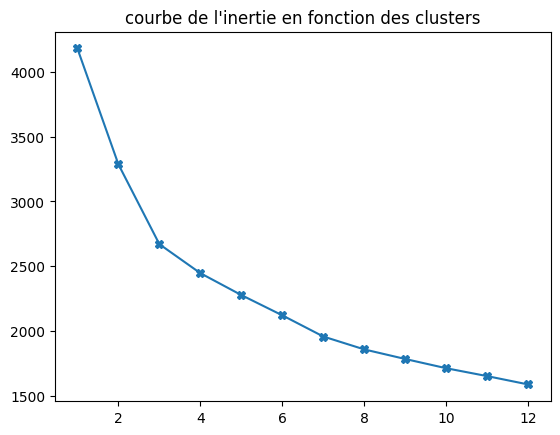

In [ ]:

inertie=[]
for c in  range (1, 13):
  kmeans = KMeans (init = 'k-means++' , n_clusters=c)
  kmeans.fit(data_scaled)
  inertie.append(kmeans.inertia_)
print (inertie)
plt.figure()
plt.plot(range(1,13) , inertie,marker='X')
plt.title("courbe de l'inertie en fonction des clusters")
plt.show()


Shape of data_pca: (190, 3)
Shape of yb: (190,)

Matrice de confusion :


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


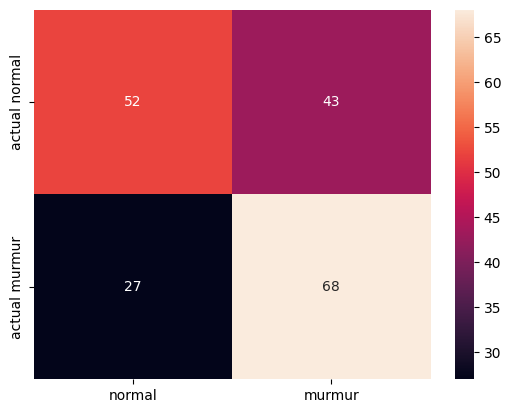


Score de précision : 0.7052631578947368


In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Réduction de dimension avec PCA
n_components = 3
pca = PCA(n_components=n_components)
data_pca = pca.fit_transform(data_scaled)

print("Shape of data_pca:", data_pca.shape)
print("Shape of yb:", yb.shape)

kmeans = KMeans(n_clusters=2, random_state=0)
y_pred = kmeans.fit_predict(data_pca)
y_pred_label = correspondance(y_pred, yb)

# Calcul de la matrice de confusion
cm = confusion_matrix(yb, y_pred_label)

# Calcul du score de précision
accuracy = accuracy_score(yb, y_pred_label)

class_labelsX = [ 'normal', 'murmur']
class_labelsY = [ 'actual normal', 'actual murmur']


print("\nMatrice de confusion :")
sns.heatmap(mc,annot=True,fmt="d" , xticklabels=class_labelsX, yticklabels=class_labelsY )
plt.show()

print("\nScore de précision :", accuracy)
